#Importing necessary libraries and dropping irrelevant columns

In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from sklearn.model_selection import GridSearchCV
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix


df = pd.read_csv("C:/Users/Tanuj/Desktop/reviews.csv")
df = df.drop('Unnamed: 0', axis=1)
print(df.head())

   review_rating                                        review_text
0              1  Definitely gone downhill. Just had my parcel d...
1              1  Couriers are always rushing and generally thro...
2              4  I have been a loyal Amazon customer for many y...
3              1  Parcels NOT delivered yet again. Items returne...
4              1  I would give Amazon zero stars if I could.Orde...


#Checking length of dataset and null values

In [2]:
length=len(df)
print(length)
df.columns
null_counts = df.isnull().sum()
print(null_counts)

8920
review_rating      0
review_text      226
dtype: int64


In [3]:
df = df.dropna(subset=['review_text'])
null_counts = df.isnull().sum()
print(null_counts)

review_rating    0
review_text      0
dtype: int64


In [4]:
print(df["review_rating"].value_counts())

1    6509
5     922
2     611
4     327
3     325
Name: review_rating, dtype: int64


In [5]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#visualising  the distribution of review ratings,lenth of reviews and word cloud

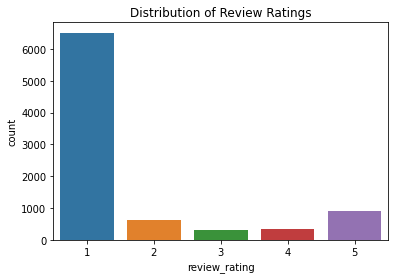

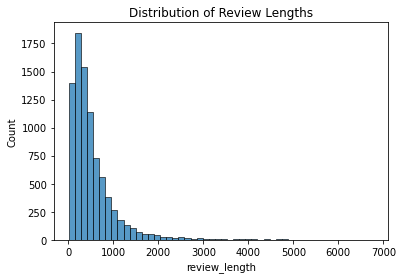

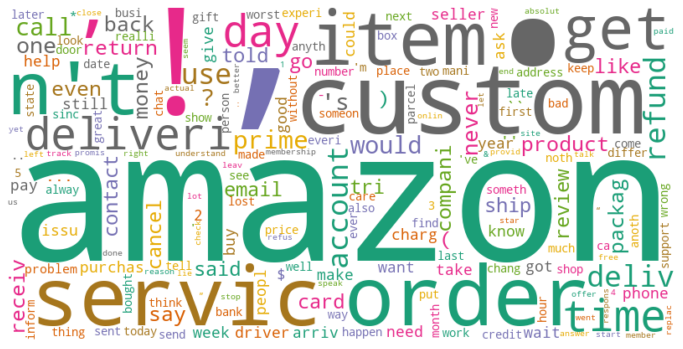

In [6]:
sns.countplot(data=df, x='review_rating')
plt.title('Distribution of Review Ratings')
plt.show()

df['review_length'] = df['review_text'].apply(lambda x: len(x))
sns.histplot(data=df, x='review_length', bins=50)
plt.title('Distribution of Review Lengths')
plt.show()

stemmer = PorterStemmer()
stop_words = set(nltk.corpus.stopwords.words('english'))

def tokenize(text):
    tokens = word_tokenize(text.lower())
    stemmed = [stemmer.stem(token) for token in tokens if token not in stop_words]
    return stemmed

words = df['review_text'].apply(tokenize).explode().value_counts()
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Dark2').generate_from_frequencies(words)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


#Preparing data for NBC

In [7]:
df["sentiment"] = df["review_rating"].apply(lambda x: "negative" if x <= 2 else ("positive" if x >= 4 else "neutral"))
def tokenize(text):
    tokens = word_tokenize(text.lower())
    stemmed = [stemmer.stem(token) for token in tokens if token not in stop_words]
    return stemmed
print(df["sentiment"])

0       negative
1       negative
2       positive
3       negative
4       negative
          ...   
8915    positive
8916    negative
8917     neutral
8918    negative
8919    positive
Name: sentiment, Length: 8694, dtype: object


#Applying NBC with TF-IDF vector representation and gridsearch

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df["review_text"], df["sentiment"], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(tokenizer=tokenize)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

param_grid = {
    'alpha': np.linspace(0.1, 1, 10),
    'fit_prior': [True, False]
}
grid_search = GridSearchCV(MultinomialNB(), param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_vectorized, y_train)
print("Best parameters found: ", grid_search.best_params_)

clf = MultinomialNB(alpha=grid_search.best_params_['alpha'], fit_prior=grid_search.best_params_['fit_prior'])
clf.fit(X_train_vectorized, y_train)


Best parameters found:  {'alpha': 0.2, 'fit_prior': False}


MultinomialNB(alpha=0.2, fit_prior=False)

PLotting heatmap for grid results

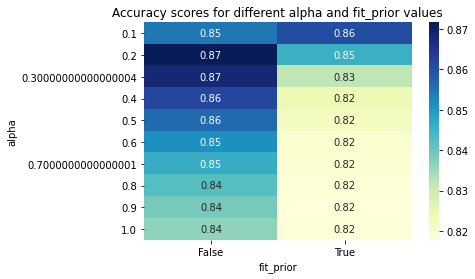

In [9]:
results = pd.DataFrame(grid_search.cv_results_)
heatmap_data = results.pivot_table(values='mean_test_score', index='param_alpha', columns='param_fit_prior')
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
plt.title("Accuracy scores for different alpha and fit_prior values")
plt.xlabel("fit_prior")
plt.ylabel("alpha")
plt.show()

#Evaluate the performance

In [10]:
y_pred = clf.predict(X_test_vectorized)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8993674525589419
Precision: 0.8705459622486313
Recall: 0.8993674525589419
F1-score: 0.879897500278909

Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.99      0.94      1433
     neutral       0.00      0.00      0.00        56
    positive       0.87      0.60      0.71       250

    accuracy                           0.90      1739
   macro avg       0.59      0.53      0.55      1739
weighted avg       0.87      0.90      0.88      1739



Plotting curves

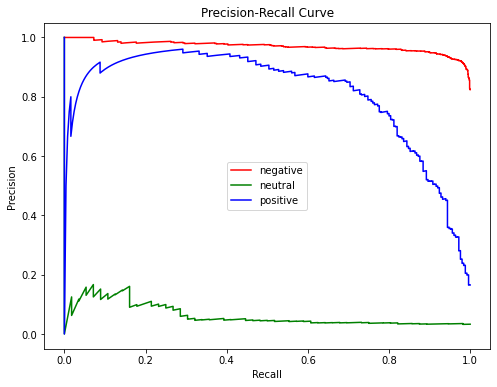

In [11]:
y_test_binarized = label_binarize(y_test, classes=["negative", "neutral", "positive"])
y_score = clf.predict_proba(X_test_vectorized)
precision = dict()
recall = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
plt.figure(figsize=(8, 6))
for i, color, label in zip(range(3), ["red", "green", "blue"], ["negative", "neutral", "positive"]):
    plt.plot(recall[i], precision[i], color=color, label=label)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()

Plotting Confusion Matrix

c:\Users\harsh\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


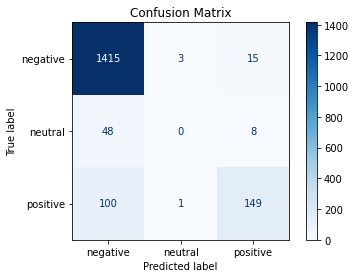

In [12]:
y_pred = clf.predict(X_test_vectorized)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(clf, X_test_vectorized, y_test, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

PLotting distribution of sentiments

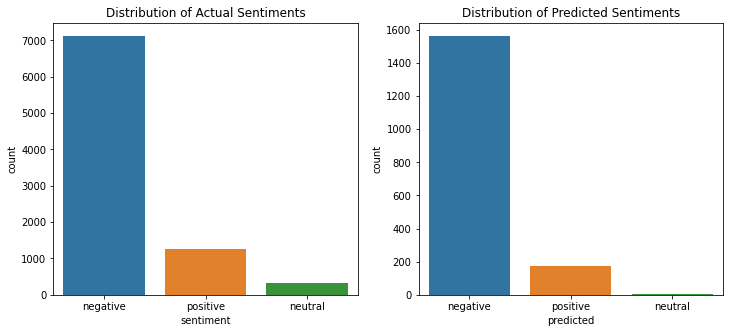

In [13]:
predicted_df = pd.DataFrame({"actual": y_test, "predicted": y_pred})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(data=df, x="sentiment", ax=ax1)
ax1.set_title("Distribution of Actual Sentiments")
sns.countplot(data=predicted_df, x="predicted", ax=ax2)
ax2.set_title("Distribution of Predicted Sentiments")
plt.show()


Plotting top 20 feature of Negative(0),Neutral(1) and Positive(2) sentiments

c:\Users\harsh\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\harsh\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


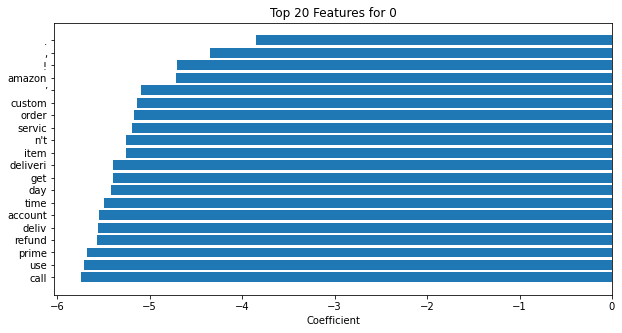

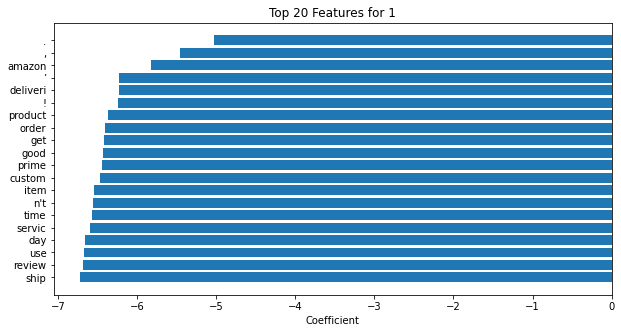

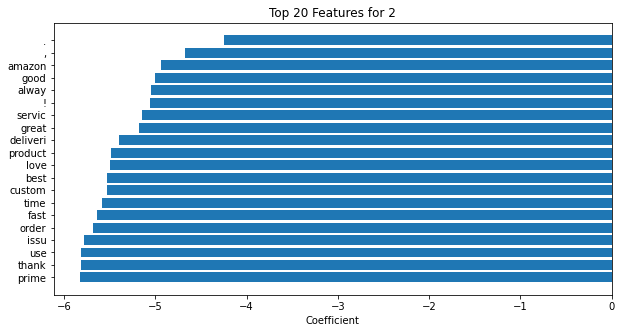

In [14]:
def plot_top_features(classifier, vectorizer, n_features, class_label):
    feature_names = np.array(vectorizer.get_feature_names())
    top_features = np.argsort(classifier.coef_[class_label])[-n_features:]
    plt.figure(figsize=(10, 5))
    plt.barh(range(n_features), classifier.coef_[class_label][top_features])
    plt.yticks(range(n_features), feature_names[top_features])
    plt.xlabel("Coefficient")
    plt.title(f"Top {n_features} Features for {class_label}")
    plt.show()
plot_top_features(clf, vectorizer, 20, 0) 
plot_top_features(clf, vectorizer, 20, 1) 
plot_top_features(clf, vectorizer, 20, 2)  
